In [1]:
import numpy as np
import random
import pickle
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch import optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()
    


In [3]:
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, anchor, positive, negative):
        output1 = self.embedding_net(anchor)
        output2 = self.embedding_net(positive)
        output3 = self.embedding_net(negative)
        return output1, output2, output3
    
    def get_embedding(self, x):
        return self.embedding_net(x)


In [4]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        
        self.fc = nn.Sequential(nn.Linear(300, 100),
                                nn.PReLU(),
                                nn.Linear(100, 2))        

    def forward(self, x):
        output = self.fc(x)
        return output

    def get_embedding(self, x):
        return self.forward(x)


In [5]:
class TripletDataset(Dataset):

    def __init__(self, dataset):
        self.dataset = dataset
        self.keys = list(dataset.keys())

    def __getitem__(self, index):
        word = self.keys[index]
        
        anchor = self.dataset[word]['word_vector'] 
        positive = self.dataset[word]['antonym_vector']
        
        negative_word = word
        while (negative_word == word) | (negative_word == self.dataset[word]['antonym']):
            negative_word = np.random.choice(self.keys)    
            negative = self.dataset[negative_word]['word_vector']
        
        
        return (anchor, positive, negative), []

    def __len__(self):
        return len(self.dataset)

In [6]:
class WordDataset(Dataset):
    def __init__(self, dataset, antonym=False):
        self.dataset = dataset
        self.keys = list(dataset.keys())
        self.antonym = antonym
    
    def __getitem__(self, index):
        word = self.keys[index]
        embedding = self.dataset[word]['word_vector']
        if self.antonym:
            embedding = self.dataset[word]['antonym_vector']

        return embedding
    
    def __len__(self):
        return len(self.dataset)

In [7]:
def plotter(history):
    _hist = np.array(history)
    train_loss, val_loss = _hist[:, 1], _hist[:, 2]

    clear_output(True)
    plt.figure(figsize=(12, 4))
    # plt.subplot(1, 2, 1)
    plt.title('loss')
    plt.plot(train_loss, label='train loss')
    plt.plot(val_loss, label='vall loss')
    plt.grid()
    plt.legend()

    plt.show()
    
    for epoch, train_loss, val_loss in history:
        print(f'Epoch {epoch}')
        print('Train Loss: {:.4f}'.format(train_loss),
              '| Val Loss: {:.4f}'.format(val_loss))
        print()


In [8]:
with open('./fasttext-wiki-news-subwords-300_5120.pickle', 'rb') as f:
    data = pickle.load(f)
len(data)

5120

In [9]:
train = dict(list(data.items())[:4000])
val = dict(list(data.items())[4000:])

len(train), len(val)

(4000, 1120)

In [9]:
triplet_train_dataset = TripletDataset(train) 
train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=31, shuffle=True)

triplet_val_dataset = TripletDataset(val) 
val_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=31, shuffle=True)


In [11]:

embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
loss_fn = TripletLoss(margin = 1.)

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, last_epoch=-1)


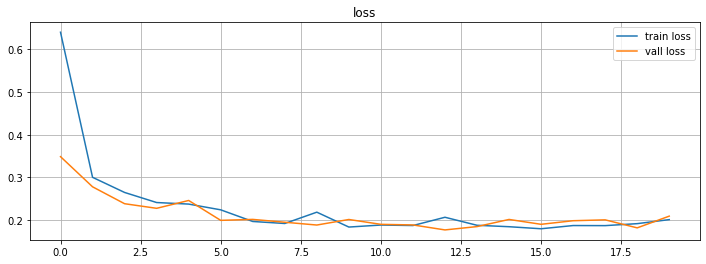

Epoch 0
Train Loss: 0.6398 | Val Loss: 0.3487

Epoch 1
Train Loss: 0.3003 | Val Loss: 0.2781

Epoch 2
Train Loss: 0.2649 | Val Loss: 0.2385

Epoch 3
Train Loss: 0.2413 | Val Loss: 0.2278

Epoch 4
Train Loss: 0.2377 | Val Loss: 0.2461

Epoch 5
Train Loss: 0.2242 | Val Loss: 0.1996

Epoch 6
Train Loss: 0.1970 | Val Loss: 0.2018

Epoch 7
Train Loss: 0.1923 | Val Loss: 0.1952

Epoch 8
Train Loss: 0.2188 | Val Loss: 0.1887

Epoch 9
Train Loss: 0.1839 | Val Loss: 0.2016

Epoch 10
Train Loss: 0.1887 | Val Loss: 0.1903

Epoch 11
Train Loss: 0.1875 | Val Loss: 0.1889

Epoch 12
Train Loss: 0.2068 | Val Loss: 0.1772

Epoch 13
Train Loss: 0.1881 | Val Loss: 0.1850

Epoch 14
Train Loss: 0.1847 | Val Loss: 0.2017

Epoch 15
Train Loss: 0.1799 | Val Loss: 0.1904

Epoch 16
Train Loss: 0.1875 | Val Loss: 0.1988

Epoch 17
Train Loss: 0.1873 | Val Loss: 0.2008

Epoch 18
Train Loss: 0.1919 | Val Loss: 0.1821

Epoch 19
Train Loss: 0.2013 | Val Loss: 0.2095



In [12]:
n_epochs = 20

train_len = len(train_loader)
val_len = len(val_loader)

history = []


for epoch in range(n_epochs):
    
    model.train()
    train_loss = 0
    val_loss = 0
    
    scheduler.step()
    for batch_idx, (data, _) in tqdm(enumerate(train_loader), desc="Iteration"):
        optimizer.zero_grad()
        outputs = model(*data)
        loss = loss_fn(*outputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval();
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(val_loader), desc="Iteration"):
            outputs = model(*data)
            loss = loss_fn(*outputs)
            val_loss += loss.item()
            
    epoch_train_loss = train_loss / train_len
    epoch_val_loss = val_loss / val_len
    history.append([epoch, epoch_train_loss, epoch_val_loss])
    
    plotter(history)
    

In [19]:
def extract_embeddings(dataloader, model):
    result = []
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        for data in tqdm(dataloader):
            result.append(model.get_embedding(data))

    return np.concatenate(result)

In [107]:
wd = WordDataset(val)
ad = WordDataset(val,antonym=True)

word_loader = torch.utils.data.DataLoader(wd, batch_size=31, shuffle=True)
antonym_loader = torch.utils.data.DataLoader(ad, batch_size=31, shuffle=True)


In [109]:
w_emb = extract_embeddings(word_loader,model)
a_emb = extract_embeddings(antonym_loader,model)

100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 2473.29it/s]


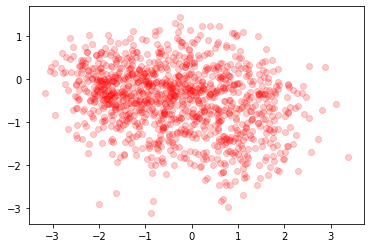

In [110]:
plt.scatter(w_emb[:,0], w_emb[:,1], c='r', alpha=0.2)

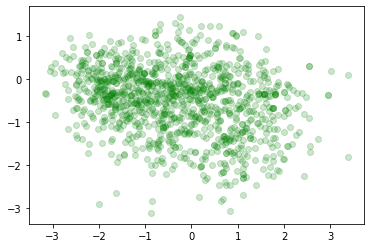

In [111]:
plt.scatter(a_emb[:,0], a_emb[:,1], c='g', alpha=0.2)


In [10]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

In [11]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

In [12]:
class SiameseDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.keys = list(dataset.keys())
    def __getitem__(self, index):
        word = self.keys[index]
        word_embedding = self.dataset[word]['word_vector']
        
        target = np.random.randint(0,2)
        if target:
            siam_embedding = self.dataset[word]['antonym_vector']
        else:
            _word = np.random.choice(self.keys)    
            siam_embedding = self.dataset[_word]['word_vector']
        return (word_embedding, siam_embedding), target
    
    def __len__(self):
        return len(self.dataset)

In [13]:
siamese_train_dataset = SiameseDataset(train)
siamese_val_dataset = SiameseDataset(val)

train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=31, shuffle=True)
val_loader = torch.utils.data.DataLoader(siamese_val_dataset, batch_size=31, shuffle=True)


In [14]:
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)

In [15]:
loss_fn = ContrastiveLoss(margin=1.)
lr = 1e-3

In [16]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)


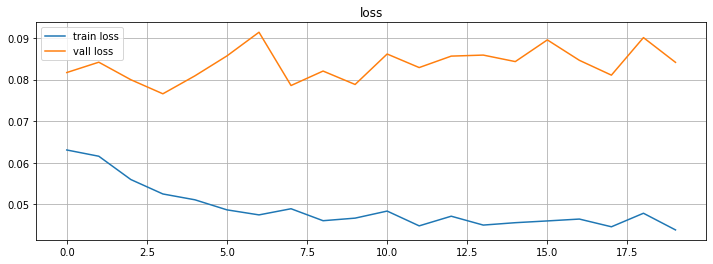

Epoch 0
Train Loss: 0.0631 | Val Loss: 0.0817

Epoch 1
Train Loss: 0.0615 | Val Loss: 0.0842

Epoch 2
Train Loss: 0.0559 | Val Loss: 0.0800

Epoch 3
Train Loss: 0.0525 | Val Loss: 0.0766

Epoch 4
Train Loss: 0.0511 | Val Loss: 0.0809

Epoch 5
Train Loss: 0.0487 | Val Loss: 0.0857

Epoch 6
Train Loss: 0.0474 | Val Loss: 0.0914

Epoch 7
Train Loss: 0.0489 | Val Loss: 0.0786

Epoch 8
Train Loss: 0.0460 | Val Loss: 0.0820

Epoch 9
Train Loss: 0.0467 | Val Loss: 0.0788

Epoch 10
Train Loss: 0.0484 | Val Loss: 0.0861

Epoch 11
Train Loss: 0.0448 | Val Loss: 0.0829

Epoch 12
Train Loss: 0.0471 | Val Loss: 0.0856

Epoch 13
Train Loss: 0.0450 | Val Loss: 0.0859

Epoch 14
Train Loss: 0.0456 | Val Loss: 0.0843

Epoch 15
Train Loss: 0.0460 | Val Loss: 0.0895

Epoch 16
Train Loss: 0.0464 | Val Loss: 0.0846

Epoch 17
Train Loss: 0.0446 | Val Loss: 0.0811

Epoch 18
Train Loss: 0.0478 | Val Loss: 0.0901

Epoch 19
Train Loss: 0.0438 | Val Loss: 0.0841



In [18]:
n_epochs = 20

train_len = len(train_loader)
val_len = len(val_loader)

history = []


for epoch in range(n_epochs):

    model.train()
    train_loss = 0
    val_loss = 0

    scheduler.step()
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), desc="Iteration"):
        optimizer.zero_grad()
        outputs = model(*data)
        loss = loss_fn(outputs[0],outputs[1], target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval();
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(val_loader), desc="Iteration"):
            outputs = model(*data)
            loss = loss_fn(outputs[0],outputs[1], target)
            val_loss += loss.item()

    epoch_train_loss = train_loss / train_len
    epoch_val_loss = val_loss / val_len
    history.append([epoch, epoch_train_loss, epoch_val_loss])

    plotter(history)

In [22]:
def extract_embeddings(dataloader, model):
    result = []
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        for data in tqdm(dataloader):
            result.append(model.get_embedding(data))

    return np.concatenate(result)

In [23]:
wd = WordDataset(val)
ad = WordDataset(val,antonym=True)

word_loader = torch.utils.data.DataLoader(wd, batch_size=31, shuffle=True)
antonym_loader = torch.utils.data.DataLoader(ad, batch_size=31, shuffle=True)

In [24]:
extract_embeddings(word_loader, model)

100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 2649.95it/s]


array([[-0.52912194,  0.44408378],
       [-0.76398635,  0.7121565 ],
       [ 0.13898127,  0.43675774],
       ...,
       [-1.0416143 ,  0.49211577],
       [-0.64724743,  0.6681307 ],
       [ 0.25725654,  0.46035284]], dtype=float32)

In [25]:
w_emb = extract_embeddings(word_loader,model)
a_emb = extract_embeddings(antonym_loader,model)

100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 2650.13it/s]


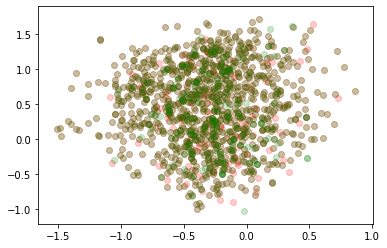

In [29]:
plt.scatter(w_emb[:,0], w_emb[:,1], c='r', alpha=0.2)
plt.scatter(a_emb[:,0], a_emb[:,1], c='g', alpha=0.2)
